# Секция Импорта библиотек

In [23]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras.models import Sequential
import  numpy as np
import pandas as pd
import os, sys
from os import listdir
import zipfile
from tqdm import tqdm
from sklearn.utils import shuffle

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG19

from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

import matplotlib.pyplot as plt   
from PIL import Image

# Загрузка тренировочных данных

In [2]:
PATH = '/content/drive/MyDrive/DS и ML/'
CAT_FOLDER = './Cat/'
DOG_FOLDER =  './Dog/'
DATA_FOLDER =  './Data/'
IMG_SIZE = 224

In [3]:
# Путь до архива
cat_image_path = os.path.join(PATH, "Cat.zip")
dog_image_path = os.path.join(PATH, "Dog.zip")

In [4]:
# Извлечение данных из архива
with zipfile.ZipFile(cat_image_path,"r") as z:
    z.extractall(".")
with zipfile.ZipFile(dog_image_path,"r") as z:
    z.extractall(".")

In [3]:
# Получаем список файлов в директориях
cat_image_list = os.listdir(CAT_FOLDER)
dog_image_list = os.listdir(DOG_FOLDER)

In [4]:
# Функция переименования картинок на Cat_name.jpg и Dog_name.jpg
def rename_files(path, data_image_list, prefix):
  for img in tqdm(data_image_list):
    os.rename(path+img,path+prefix+img)

In [5]:
rename_files(CAT_FOLDER, cat_image_list, 'cat_')
rename_files(DOG_FOLDER, dog_image_list, 'dog_')

100%|██████████████████████████████████████████████████████████████████████████| 12499/12499 [00:09<00:00, 1265.47it/s]


## Создание каталогов с папками Cat и Dog

In [6]:
# Создание директории Data, где будут храниться все картинки
!mkdir Data

In [9]:
# Создание поддиректории Cat в Data
!cp -rp Cat/* Data/

"cp" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [10]:
# Создание поддиректории Dog в Data
!cp -rp Dog/* Data/

"cp" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [4]:
data_image_list = os.listdir(DATA_FOLDER)

In [5]:
labels = []
for lbl in data_image_list:
  labels.append(lbl.split('_')[0])
label = np.array(labels)

In [6]:
data_df = pd.DataFrame({'list':data_image_list, 'label':label})

In [7]:
data = shuffle(data_df)

In [8]:
data['label'] = data['label'].apply(lambda x: 1 if x == 'cat' else 0)

In [9]:
train_list =  data.iloc[:int(data.shape[0]*0.67), 0].values
test_list =  data.iloc[int(data.shape[0]*0.67):, 0].values
y_train = data.iloc[:int(data.shape[0]*0.67), 1].values
y_test = data.iloc[int(data.shape[0]*0.67):, 1].values

In [10]:
preprocess = imagenet_utils.preprocess_input

def process_data(data_image_list):
    data_df = []
    for img in tqdm(data_image_list):
        path = os.path.join(DATA_FOLDER,img)
        img = load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
        img = np.resize(img, (IMG_SIZE, IMG_SIZE, 3))
        img = preprocess(img)
        data_df.append(img)
    return np.array(data_df)

In [11]:
x_train = process_data(train_list)

 59%|█████████████████████████████████████████████▏                              | 9959/16748 [01:39<00:44, 152.47it/s]C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|████████████████████████████████████████████████████████████████████████████| 16748/16748 [03:50<00:00, 72.68it/s]


In [12]:
x_test = process_data(test_list)

100%|█████████████████████████████████████████████████████████████████████████████| 8250/8250 [01:16<00:00, 108.15it/s]


# ResNet 50

## Transfer Learning

In [13]:
model = Sequential()

model.add(tf.keras.applications.resnet50.ResNet50(
                                input_shape = (IMG_SIZE,IMG_SIZE,3), 
                                include_top = False, 
                                weights = 'imagenet'))

model.add(L.Flatten())

model.add(L.Dense(1, activation='sigmoid'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
for layer in model.layers[0].layers:
    if layer.name == 'conv5_block1_0_conv':
        break
    layer.trainable=False

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 1)                 100353    
                                                                 
Total params: 23,688,065
Trainable params: 12,189,697
Non-trainable params: 11,498,368
_________________________________________________________________


## Обучение модели

In [16]:
model.fit(x_train, y_train.reshape((-1,1)),
          batch_size=32, epochs=3,
          verbose=1)

Epoch 1/3
524/524 [==============================] - 4911s 9s/step - loss: 0.0932 - accuracy: 0.9685
Epoch 2/3
524/524 [==============================] - 4992s 10s/step - loss: 0.0176 - accuracy: 0.9937
Epoch 3/3
524/524 [==============================] - 5010s 10s/step - loss: 0.0148 - accuracy: 0.9953


## Оценка модели

In [17]:
model.evaluate(x_test,y_test.reshape((-1,1)))

258/258 [==============================] - 548s 2s/step - loss: 0.0466 - accuracy: 0.9834


[0.046643856912851334, 0.9833939671516418]

# VGG 19

## Transfer Learning

In [73]:
model = Sequential()

model.add(tf.keras.applications.vgg19.VGG19(input_shape = (IMG_SIZE,IMG_SIZE,3), 
                                include_top = False, 
                                weights = 'imagenet'))
model.add(L.Flatten())

model.add(L.Dense(128, activation='relu'))

model.add(L.Dense(1, activation='sigmoid'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [74]:
for layer in model.layers[0].layers:
    if layer.name == 'block5_pool':
        break
    layer.trainable=False

In [75]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_9 (Dense)             (None, 128)               3211392   
                                                                 
 dense_10 (Dense)            (None, 1)                 129       
                                                                 
Total params: 23,235,905
Trainable params: 3,211,521
Non-trainable params: 20,024,384
_________________________________________________________________


In [76]:
model.fit(x_train, y_train.reshape((-1,1)),
          batch_size=32, epochs=3,
          verbose=1)

Epoch 1/3
524/524 [==============================] - 11145s 21s/step - loss: 0.3305 - accuracy: 0.8624
Epoch 2/3
524/524 [==============================] - 12294s 23s/step - loss: 0.1073 - accuracy: 0.9586
Epoch 3/3
524/524 [==============================] - 13012s 25s/step - loss: 0.0735 - accuracy: 0.9727


In [77]:
model.evaluate(x_test,y_test.reshape((-1,1)))

258/258 [==============================] - 1584s 6s/step - loss: 0.0594 - accuracy: 0.9756


[0.05944375693798065, 0.97563636302948]

# Загрузка собственной картинки Resnet50

In [67]:
list_of_path = ["cat_1.jpg", "cat_2.jpg", "cat_3.jpg", "dog_1.jpg", "dog_2.jpg"]

In [76]:
def predict_cat_dog(list_of_path):
    
    plt.figure(figsize=(10, 15))
    for i, path in enumerate (list_of_path):
        plt.subplot(3,3,i+1)
        img = load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
        plt.imshow(img, interpolation='none')
        
        img = np.resize(img, (IMG_SIZE, IMG_SIZE, 3))
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess(img)
        
        if model.predict(img)[0][0] > 0.5:
            label = 'Cat'
        else:
            label = 'Dog'
        
        plt.title("Class {}".format(label))
    plt.tight_layout()

1/1 [==============================] - 0s 357ms/step


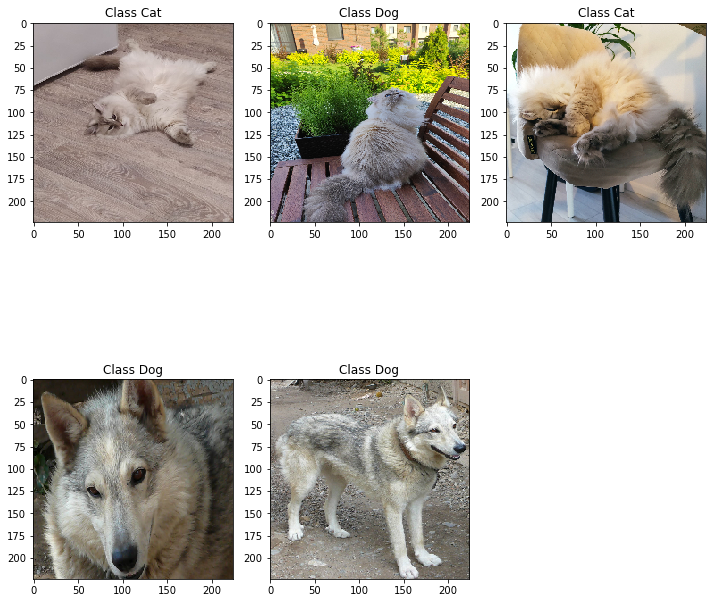

In [77]:
predict_cat_dog(list_of_path)